In [2]:
import numpy as np

# Importing standard Qiskit libraries
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from qiskit.visualization import plot_histogram
from qiskit.algorithms.optimizers import COBYLA

from qiskit import *
import qiskit.quantum_info as qi
from qiskit.tools.visualization import plot_histogram
from qiskit.providers.aer import AerSimulator
from qiskit.providers.aer.noise import *
import math
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
pi = math.pi

In [63]:
T1 = 100000 # in ns
T2 = 100000 # considering T2 = T1, since it is not very important here

noise_model = NoiseModel()

err = thermal_relaxation_error(T1,T2,500)
noise_model.add_all_qubit_quantum_error(err,'delay')
backend = AerSimulator(noise_model=noise_model)

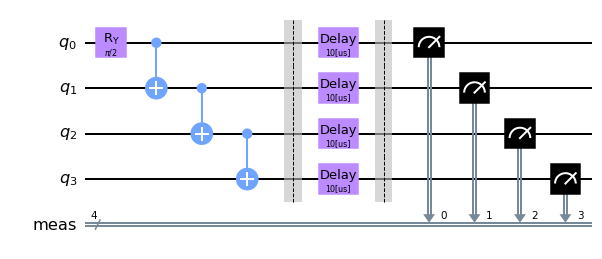

In [64]:
def U_prep(n_qubits,theta):
  qc = QuantumCircuit(n_qubits)
  qc.ry(theta,0)
  for qubit in range(n_qubits-1):
    qc.cx(qubit,qubit+1)
  qc.barrier()
  return qc

qc_without_hadamard = U_prep(4,pi/2)
qc_without_hadamard.delay(10,unit='us')
qc_without_hadamard.measure_all()
qc_without_hadamard.draw('mpl')

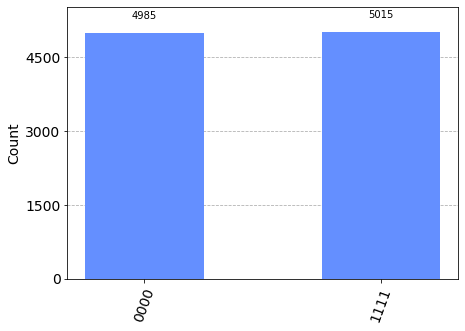

In [65]:
#Backend without Noise
results_ideal = AerSimulator().run(qc_without_hadamard,shots=10000).result()
counts_ideal = results_ideal.get_counts()
plot_histogram(counts_ideal)


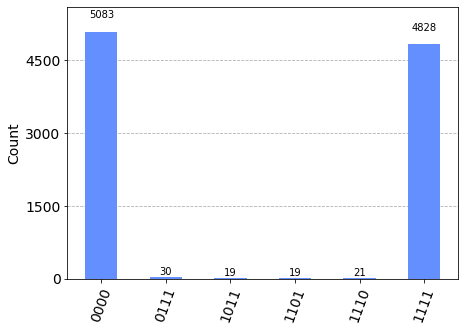

In [66]:
#Backend with noise
counts_without_hadamard = backend.run(qc_without_hadamard,shots=10000).result().get_counts()
plot_histogram(counts_without_hadamard)

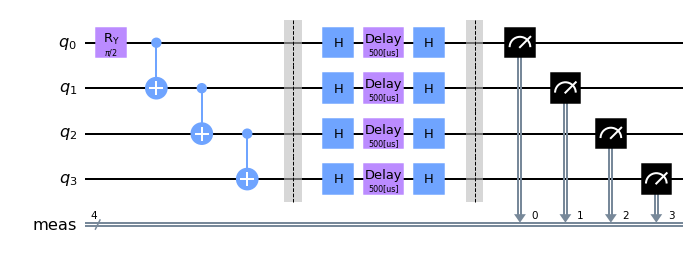

In [67]:
def padded_circuit(n_qubits,theta,delay):
  qc = U_prep(n_qubits,theta)

  for qubit in range(n_qubits):
    qc.h(qubit)
    qc.delay(delay,qubit,unit='us')
    qc.h(qubit)
  qc.measure_all()
  return qc

qc_with_hadamard = padded_circuit(4,pi/2, 500)
qc_with_hadamard.draw('mpl')


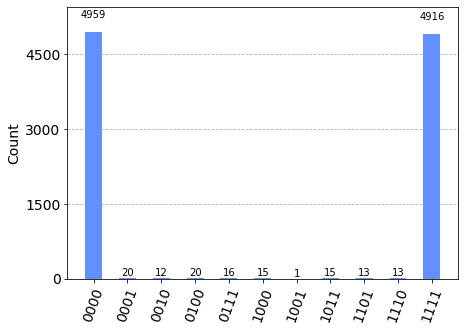

In [68]:
#Backend with Noise and padding both sides with the Hadamard gate
counts_with_hadamard = backend.run(qc_with_hadamard,shots=10000).result().get_counts()
plot_histogram(counts_with_hadamard)

In [69]:
# If state is not in the set of valid states, ouput is erroneous
def cost(counts):
  invalid_states_count = 0
  diff = 0
  counts = dict(counts)
  for state in counts.keys():
    if (state != '0000') and (state != '1111'):
      invalid_states_count += counts[state]
    # probability of getting the other 8 valid states is 5000/10000
    else:
        if (counts[state]-5000 >= 0):
            diff += abs(counts[state]-5000) # we got a valid state but how far is it from the ideal value? i.e deviation from correct value
  total_error = round((invalid_states_count + diff)/10000 , 4 )
  return {'invalid_states_count':invalid_states_count, 'deviation' : diff, 'error':total_error }


In [70]:
# counts = backend.run(qc,shots=10000).result().get_counts()
print(f"Error without noise: {cost(counts_ideal)}")
print(f"Error with noise without hadamard: {cost(counts_without_hadamard)}")
print(f"Error with noise with hadamard: {cost(counts_with_hadamard)}")

Error without noise: {'invalid_states_count': 0, 'deviation': 15, 'error': 0.0015}
Error with noise without hadamard: {'invalid_states_count': 89, 'deviation': 83, 'error': 0.0172}
Error with noise with hadamard: {'invalid_states_count': 125, 'deviation': 0, 'error': 0.0125}


In [71]:
# Complete this function
def pad_circuits_with_gates(n_qubits,theta,delay):  
  qc = U_prep(n_qubits,theta)
  range_low, increment = 0, pi/32
  range_high = 2*pi - increment
  circuits = []
 
  
  angle1 = range_low
  while(angle1 <= range_high): # u = rx, v = rx
    angle2 = range_low
    while(angle2 <= range_high):

      qc_pad = qc.copy()

      for qubit in range(n_qubits):     # u = rx
        qc_pad.rx(angle1,qubit)

      qc_pad.delay(delay,unit='ns')

      for qubit in range(n_qubits):     # v = rx
        qc_pad.rx(angle2,qubit)
      
      qc_pad.measure_all()
      circuits.append((qc_pad, angle1,angle2))
      # a1.append(angle1)
      # a2.append(angle2)
      angle2 += increment
    angle1 += increment

  angle1 = range_low
  while(angle1 <= range_high): # u = rx, v = ry
    angle2 = range_low
    while(angle2 <= range_high):

      qc_pad = qc.copy()

      for qubit in range(n_qubits):     # u = rx
        qc_pad.rx(angle1,qubit)

      qc_pad.delay(delay,unit='ns')

      for qubit in range(n_qubits):     # v = ry
        qc_pad.ry(angle2,qubit)
      
      qc_pad.measure_all()
      circuits.append((qc_pad, angle1,angle2))
      # a1.append(angle1)
      # a2.append(angle2)
      angle2 += increment
    angle1 += increment

  angle1 = range_low
  while(angle1 <= range_high): # u = ry, v = rx
    angle2 = range_low
    while(angle2 <= range_high):

      qc_pad = qc.copy()

      for qubit in range(n_qubits):     # u = ry
        qc_pad.ry(angle1,qubit)

      qc_pad.delay(delay,unit='ns')

      for qubit in range(n_qubits):     # v = rx
        qc_pad.rx(angle2,qubit)
      
      qc_pad.measure_all()
      circuits.append((qc_pad, angle1,angle2))
      # a1.append(angle1)
      # a2.append(angle2)
      angle2 += increment
    angle1 += increment

  angle1 = range_low
  while(angle1 <= range_high): # u = ry, v = ry
    angle2 = range_low
    while(angle2 <= range_high):

      qc_pad = qc.copy()

      for qubit in range(n_qubits):     # u = ry
        qc_pad.ry(angle1,qubit)

      qc_pad.delay(delay,unit='ns')

      for qubit in range(n_qubits):     # v = ry
        qc_pad.ry(angle2,qubit)
      
      qc_pad.measure_all()
      circuits.append((qc_pad, angle1,angle2))
      # a1.append(angle1)
      # a2.append(angle2)
      angle2 += increment
    angle1 += increment

  return circuits

ckts = pad_circuits_with_gates(4,pi/2,500)

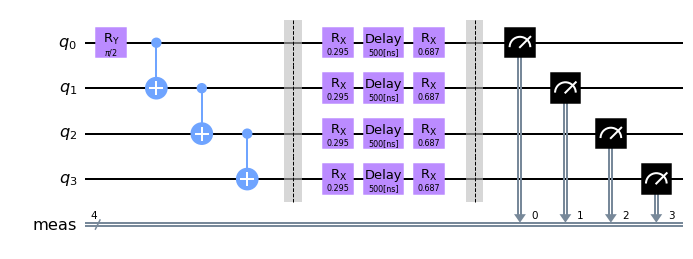

In [72]:
ckts[199][0].draw('mpl')

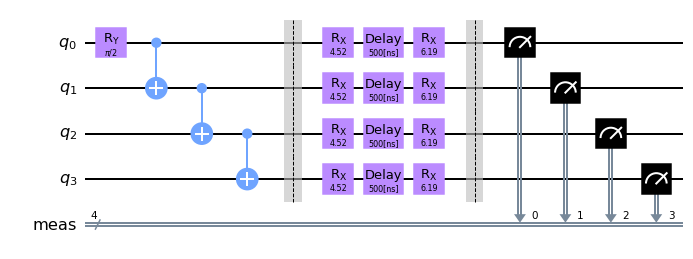

In [73]:
ckts[3007][0].draw('mpl')

In [74]:
def getError(ckt_info):
  return ckt_info['error']

In [75]:
from tqdm import tqdm
error = []

for ckt in tqdm(range(len(ckts))):
  qc = ckts[ckt][0]
  counts = backend.run(qc,shots=10000).result().get_counts()
  err = cost(counts)
  err['index'] = ckt
  error.append(err)

error.sort(key=getError)


100%|██████████| 16384/16384 [04:37<00:00, 59.02it/s]


In [76]:
print(error[0])

{'invalid_states_count': 74, 'deviation': 0, 'error': 0.0074, 'index': 13517}


optimal circuit

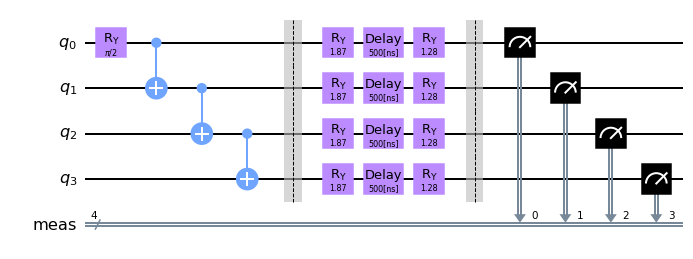

In [77]:
opt_idx = error[0]['index']
min_err_ckt = ckts[opt_idx][0]
min_err_ckt.draw('mpl')

In [78]:
errors = []
for i in range(len(ckts)):
  errors.append(error[i]['error'])

In [79]:
# for creating a responsive plot
%matplotlib widget

# Seprrating angles of U and V
x = np.array([ckt[:][1] for ckt in ckts ]) # U angle
x = np.array_split(x, len(x) / 4096)

y = np.array([ckt[:][2] for ckt in ckts ]) # V angle
y = np.array_split(y, len(y) / 4096)

z = np.array_split(np.array(errors), len(error)/4096 )


Error without applying any gate {'invalid_states_count': 89, 'deviation': 83, 'error': 0.0172}
Error after applying hadamard gate {'invalid_states_count': 125, 'deviation': 0, 'error': 0.0125}
Minimum error we found {'invalid_states_count': 74, 'deviation': 0, 'error': 0.0074, 'index': 13517}


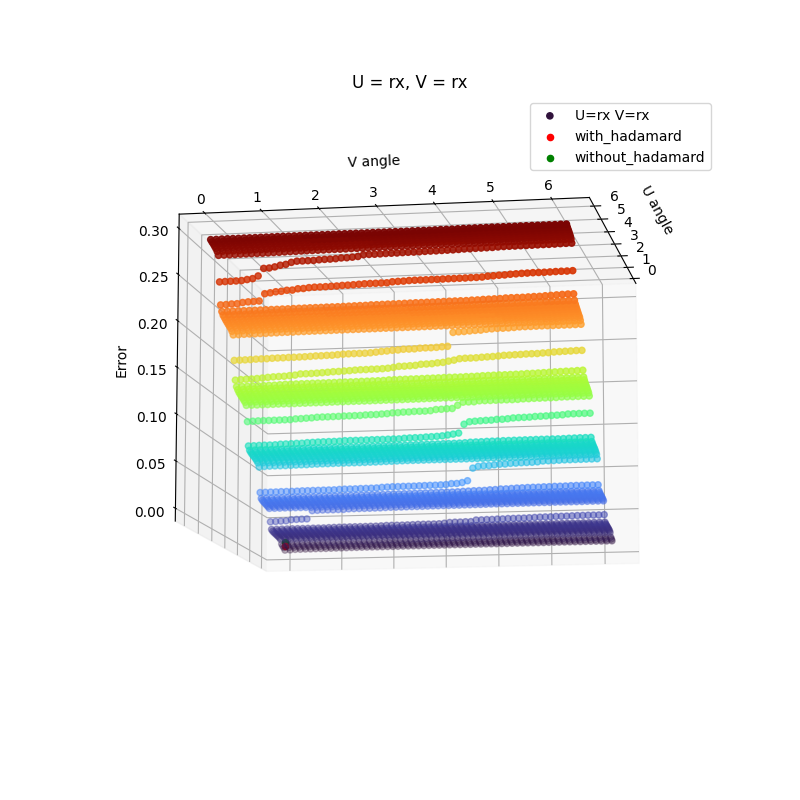

In [80]:
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection='3d')
ax.grid()
ax.set_title('U = rx, V = rx')
ax.set_xlabel('U angle')
ax.set_ylabel('V angle')
ax.set_zlabel('Error')

l1 = ax.scatter(x[0], y[0], z[0], c=z[0], cmap='turbo', label='U=rx V=rx')
l2 = ax.scatter(0,0,cost(counts_with_hadamard)['error'], color='red', label='with_hadamard')
l3 = ax.scatter(0,0,cost(counts_without_hadamard)['error'], color='green', label='without_hadamard')
ax.legend(handles=[l1, l2, l3])
ax.view_init(elev=-10, azim=10)

print(f"Error without applying any gate {cost(counts_without_hadamard)}")
print(f"Error after applying hadamard gate {cost(counts_with_hadamard)}")
print(f"Minimum error we found {error[0]}")
plt.show()

Error without applying any gate {'invalid_states_count': 89, 'deviation': 83, 'error': 0.0172}
Error after applying hadamard gate {'invalid_states_count': 125, 'deviation': 0, 'error': 0.0125}
Minimum error we found {'invalid_states_count': 74, 'deviation': 0, 'error': 0.0074, 'index': 13517}


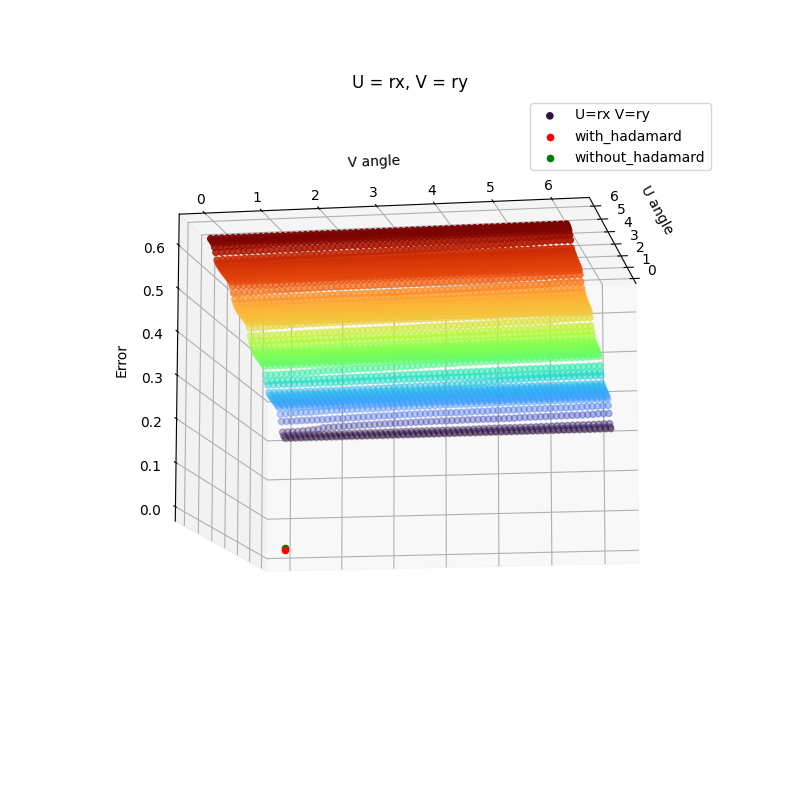

In [81]:
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection='3d')
ax.grid()
ax.set_title('U = rx, V = ry')
ax.set_xlabel('U angle')
ax.set_ylabel('V angle')
ax.set_zlabel('Error')

l1 = ax.scatter(x[1], y[1], z[1], c=z[1], cmap='turbo', label='U=rx V=ry')
l2 = ax.scatter(0,0,cost(counts_with_hadamard)['error'], color='red', label='with_hadamard')
l3 = ax.scatter(0,0,cost(counts_without_hadamard)['error'], color='green', label='without_hadamard')
ax.legend(handles=[l1, l2, l3])
ax.view_init(elev=-10, azim=10)
print(f"Error without applying any gate {cost(counts_without_hadamard)}")
print(f"Error after applying hadamard gate {cost(counts_with_hadamard)}")
print(f"Minimum error we found {error[0]}")
plt.show()

Error without applying any gate {'invalid_states_count': 89, 'deviation': 83, 'error': 0.0172}
Error after applying hadamard gate {'invalid_states_count': 125, 'deviation': 0, 'error': 0.0125}
Minimum error we found with U=ry V=rx {'invalid_states_count': 74, 'deviation': 0, 'error': 0.0074, 'index': 13517}


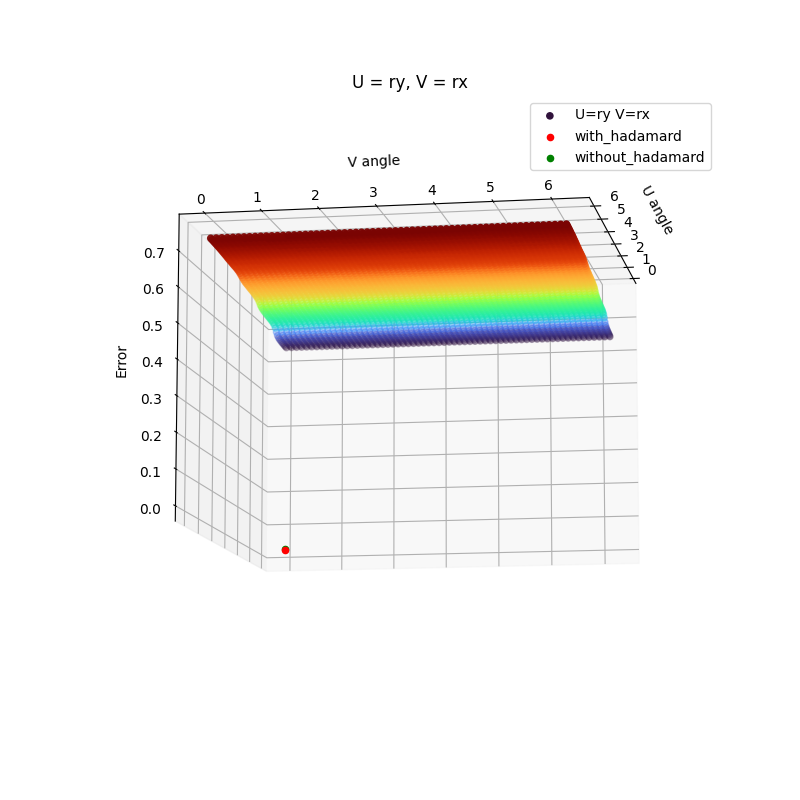

In [82]:
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection='3d')
ax.grid()
ax.set_title('U = ry, V = rx')
ax.set_xlabel('U angle')
ax.set_ylabel('V angle')
ax.set_zlabel('Error')

l1 = ax.scatter(x[2], y[2], z[2], c=z[2], cmap='turbo', label='U=ry V=rx')
l2 = ax.scatter(0,0,cost(counts_with_hadamard)['error'], color='red', label='with_hadamard')
l3 = ax.scatter(0,0,cost(counts_without_hadamard)['error'], color='green', label='without_hadamard')
ax.legend(handles=[l1, l2, l3])
ax.view_init(elev=-10, azim=10)
print(f"Error without applying any gate {cost(counts_without_hadamard)}")
print(f"Error after applying hadamard gate {cost(counts_with_hadamard)}")
print(f"Minimum error we found with U=ry V=rx {error[0]}")
plt.show()

Error without applying any gate {'invalid_states_count': 89, 'deviation': 83, 'error': 0.0172}
Error after applying hadamard gate {'invalid_states_count': 125, 'deviation': 0, 'error': 0.0125}
Minimum error we found with U=ry V=rx {'invalid_states_count': 74, 'deviation': 0, 'error': 0.0074, 'index': 13517}


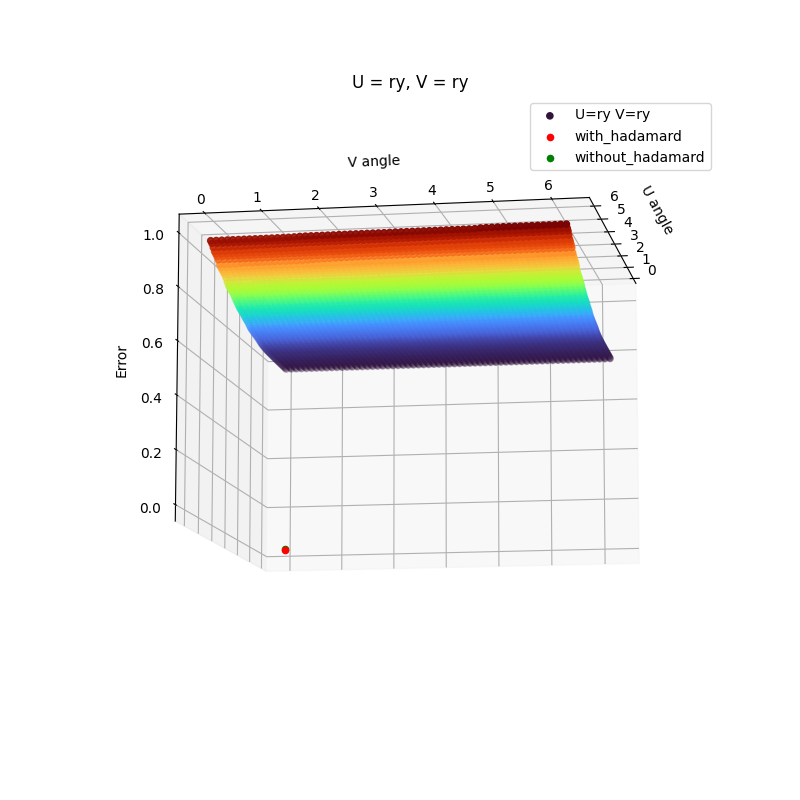

In [83]:
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection='3d')
ax.grid()
ax.set_title('U = ry, V = ry')
ax.set_xlabel('U angle')
ax.set_ylabel('V angle')
ax.set_zlabel('Error')

l1 = ax.scatter(x[3], y[3], z[3], c=z[3], cmap='turbo', label='U=ry V=ry')
l2 = ax.scatter(0,0,cost(counts_with_hadamard)['error'], color='red', label='with_hadamard')
l3 = ax.scatter(0,0,cost(counts_without_hadamard)['error'], color='green', label='without_hadamard')
ax.legend(handles=[l1, l2, l3])
ax.view_init(elev=-10, azim=10)
print(f"Error without applying any gate {cost(counts_without_hadamard)}")
print(f"Error after applying hadamard gate {cost(counts_with_hadamard)}")
print(f"Minimum error we found with U=ry V=rx {error[0]}")
plt.show()

In [85]:
from thermal_relaxation_template import thermal_relaxation as tr
min_ckt, min_err_info, min_error = tr(10000, 500)

In [16]:
from tqdm import tqdm
ckts_list = []
error_list = []
error_dict_list = []

for delay in tqdm(range(500,1200,100)):
  noise_prob = 10000
  while(noise_prob<=15000):
    print(f"@@@@@ noise_prob = {noise_prob} delay = {delay}")
    min_ckt, min_err_info, min_error = tr(noise_prob,delay)
    ckts_list.append(min_ckt)
    error_dict_list.append(min_err_info)
    error_list.append(min_error)
    noise_prob += 1000

  0%|          | 0/7 [00:00<?, ?it/s]

@@@@@ noise_prob = 10000 delay = 500


100%|██████████| 16384/16384 [05:08<00:00, 53.11it/s]


@@@@@ noise_prob = 11000 delay = 500


100%|██████████| 16384/16384 [05:05<00:00, 53.58it/s]


@@@@@ noise_prob = 12000 delay = 500


100%|██████████| 16384/16384 [05:01<00:00, 54.34it/s]


@@@@@ noise_prob = 13000 delay = 500


100%|██████████| 16384/16384 [04:51<00:00, 56.16it/s]


@@@@@ noise_prob = 14000 delay = 500


100%|██████████| 16384/16384 [04:48<00:00, 56.78it/s]


@@@@@ noise_prob = 15000 delay = 500


 14%|█▍        | 1/7 [29:49<2:58:56, 1789.36s/it]

@@@@@ noise_prob = 10000 delay = 600


100%|██████████| 16384/16384 [04:44<00:00, 57.69it/s]


@@@@@ noise_prob = 11000 delay = 600


100%|██████████| 16384/16384 [04:53<00:00, 55.76it/s]


@@@@@ noise_prob = 12000 delay = 600


100%|██████████| 16384/16384 [04:20<00:00, 62.99it/s]


@@@@@ noise_prob = 13000 delay = 600


100%|██████████| 16384/16384 [04:21<00:00, 62.65it/s]


@@@@@ noise_prob = 14000 delay = 600


100%|██████████| 16384/16384 [04:49<00:00, 56.69it/s]


@@@@@ noise_prob = 15000 delay = 600


 29%|██▊       | 2/7 [58:14<2:25:00, 1740.08s/it]

@@@@@ noise_prob = 10000 delay = 700


100%|██████████| 16384/16384 [04:26<00:00, 61.58it/s]


@@@@@ noise_prob = 11000 delay = 700


100%|██████████| 16384/16384 [04:21<00:00, 62.74it/s]


@@@@@ noise_prob = 12000 delay = 700


100%|██████████| 16384/16384 [04:21<00:00, 62.77it/s]


@@@@@ noise_prob = 13000 delay = 700


100%|██████████| 16384/16384 [03:42<00:00, 73.61it/s]


@@@@@ noise_prob = 14000 delay = 700


100%|██████████| 16384/16384 [03:34<00:00, 76.55it/s]


@@@@@ noise_prob = 15000 delay = 700


 43%|████▎     | 3/7 [1:22:40<1:47:38, 1614.62s/it]

@@@@@ noise_prob = 10000 delay = 800


100%|██████████| 16384/16384 [03:33<00:00, 76.87it/s]


@@@@@ noise_prob = 11000 delay = 800


100%|██████████| 16384/16384 [03:33<00:00, 76.92it/s]


@@@@@ noise_prob = 12000 delay = 800


100%|██████████| 16384/16384 [02:53<00:00, 94.67it/s]


@@@@@ noise_prob = 13000 delay = 800


100%|██████████| 16384/16384 [02:51<00:00, 95.46it/s]


@@@@@ noise_prob = 14000 delay = 800


100%|██████████| 16384/16384 [02:51<00:00, 95.47it/s]


@@@@@ noise_prob = 15000 delay = 800


 57%|█████▋    | 4/7 [1:41:35<1:11:15, 1425.17s/it]

@@@@@ noise_prob = 10000 delay = 900


100%|██████████| 16384/16384 [02:50<00:00, 95.82it/s]


@@@@@ noise_prob = 11000 delay = 900


100%|██████████| 16384/16384 [02:51<00:00, 95.45it/s]


@@@@@ noise_prob = 12000 delay = 900


100%|██████████| 16384/16384 [02:51<00:00, 95.50it/s]


@@@@@ noise_prob = 13000 delay = 900


100%|██████████| 16384/16384 [02:57<00:00, 92.43it/s]


@@@@@ noise_prob = 14000 delay = 900


100%|██████████| 16384/16384 [03:25<00:00, 79.81it/s]


@@@@@ noise_prob = 15000 delay = 900


 71%|███████▏  | 5/7 [2:00:19<43:53, 1316.71s/it]  

@@@@@ noise_prob = 10000 delay = 1000


100%|██████████| 16384/16384 [02:55<00:00, 93.53it/s]


@@@@@ noise_prob = 11000 delay = 1000


100%|██████████| 16384/16384 [02:57<00:00, 92.17it/s]


@@@@@ noise_prob = 12000 delay = 1000


100%|██████████| 16384/16384 [02:58<00:00, 91.89it/s]


@@@@@ noise_prob = 13000 delay = 1000


100%|██████████| 16384/16384 [02:56<00:00, 92.80it/s]


@@@@@ noise_prob = 14000 delay = 1000


100%|██████████| 16384/16384 [02:56<00:00, 92.70it/s]


@@@@@ noise_prob = 15000 delay = 1000


 86%|████████▌ | 6/7 [2:18:20<20:36, 1236.66s/it]

@@@@@ noise_prob = 10000 delay = 1100


100%|██████████| 16384/16384 [02:56<00:00, 92.83it/s]


@@@@@ noise_prob = 11000 delay = 1100


100%|██████████| 16384/16384 [02:59<00:00, 91.47it/s]


@@@@@ noise_prob = 12000 delay = 1100


100%|██████████| 16384/16384 [02:56<00:00, 93.05it/s]


@@@@@ noise_prob = 13000 delay = 1100


100%|██████████| 16384/16384 [03:02<00:00, 89.65it/s]


@@@@@ noise_prob = 14000 delay = 1100


100%|██████████| 16384/16384 [03:27<00:00, 78.99it/s]


@@@@@ noise_prob = 15000 delay = 1100


100%|██████████| 7/7 [2:37:38<00:00, 1351.27s/it]


Uncomment the lines below to load/save data

In [17]:
# import pickle
# data = {
# 'cicutes':ckts_list,
# 'error':error_list,
# 'info':error_dict_list
# }

# with open("thermal_relaxation.pkl", "wb") as file:
#     pickle.dump(data, file)

# with open("thermal_relaxation.pkl", "rb") as file:
#     pickle.load(data, file)

Error after Fixing *delay*, changing $T_1$

In [19]:
list_high = 15000
incr = 1000
idx = 10000
x_axis_T1 = []
while(idx<=list_high):
    x_axis_T1.append(round(idx, 4))
    idx += incr

list_high = 1200
incr = 100
idx = 500
x_axis_delay = []
while(idx<list_high):
    x_axis_delay.append(round(idx, 4))
    idx += incr

print(x_axis_delay, x_axis_T1)

[500, 600, 700, 800, 900, 1000, 1100] [10000, 11000, 12000, 13000, 14000, 15000]


In [20]:
len(error_list)

42

In [29]:
l_err = []

for i in range(7):
    l = []
    for j in range(6):
        l.append(error_list[i*6 + j])
    l_err.append(l)

In [30]:
l_err

[[0.0839, 0.0761, 0.0724, 0.0662, 0.0611, 0.0572],
 [0.0995, 0.0917, 0.0836, 0.0746, 0.0738, 0.0664],
 [0.1152, 0.1062, 0.0982, 0.0901, 0.0844, 0.0785],
 [0.1295, 0.1195, 0.1109, 0.1018, 0.0964, 0.0881],
 [0.1438, 0.131, 0.1232, 0.113, 0.1068, 0.0991],
 [0.1584, 0.1447, 0.1359, 0.1262, 0.1159, 0.11],
 [0.1731, 0.1567, 0.1481, 0.1376, 0.126, 0.1221]]

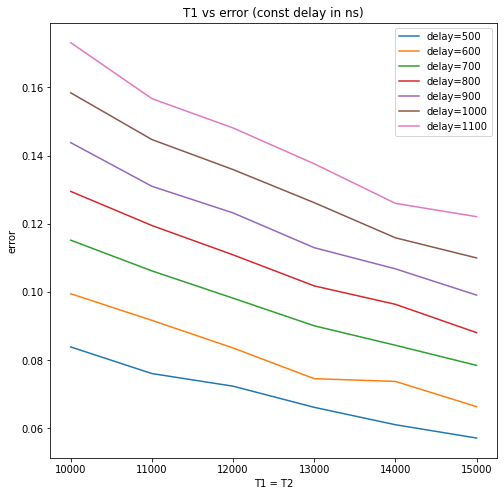

In [31]:
fig, ax = plt.subplots(figsize=(8,8))
l1 = ax.plot(x_axis_T1, l_err[0])
l2 = ax.plot(x_axis_T1, l_err[1])
l3 = ax.plot(x_axis_T1, l_err[2])
l4 = ax.plot(x_axis_T1, l_err[3])
l5 = ax.plot(x_axis_T1, l_err[4])
l6 = ax.plot(x_axis_T1, l_err[5])
l7 = ax.plot(x_axis_T1, l_err[6])
# l8 = ax.plot(x_axis_T1, l_err[7])
# l9 = ax.plot(x_axis_T1, l_err[8])
# l10 = ax.plot(x_axis_T1, l_err[9])


ax.legend(['delay=500','delay=600','delay=700','delay=800','delay=900','delay=1000','delay=1100'])
ax.set_xlabel('T1 = T2')
ax.set_ylabel('error')
ax.set_title('T1 vs error (const delay in ns)')
plt.show()

In [44]:
print(error_list)

[0.0839, 0.0761, 0.0724, 0.0662, 0.0611, 0.0572, 0.0995, 0.0917, 0.0836, 0.0746, 0.0738, 0.0664, 0.1152, 0.1062, 0.0982, 0.0901, 0.0844, 0.0785, 0.1295, 0.1195, 0.1109, 0.1018, 0.0964, 0.0881, 0.1438, 0.131, 0.1232, 0.113, 0.1068, 0.0991, 0.1584, 0.1447, 0.1359, 0.1262, 0.1159, 0.11, 0.1731, 0.1567, 0.1481, 0.1376, 0.126, 0.1221]


In [47]:
l_err = []

for i in range(6):
    l = []
    for j in range(7):
        l.append(error_list[j*6 + i])
    l_err.append(l)
# print(l_err)

In [48]:
l_err

[[0.0839, 0.0995, 0.1152, 0.1295, 0.1438, 0.1584, 0.1731],
 [0.0761, 0.0917, 0.1062, 0.1195, 0.131, 0.1447, 0.1567],
 [0.0724, 0.0836, 0.0982, 0.1109, 0.1232, 0.1359, 0.1481],
 [0.0662, 0.0746, 0.0901, 0.1018, 0.113, 0.1262, 0.1376],
 [0.0611, 0.0738, 0.0844, 0.0964, 0.1068, 0.1159, 0.126],
 [0.0572, 0.0664, 0.0785, 0.0881, 0.0991, 0.11, 0.1221]]

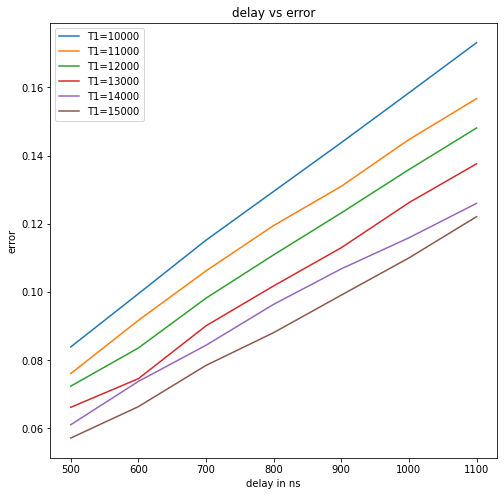

In [50]:
fig, ax = plt.subplots(figsize=(8,8))

l1 = ax.plot(x_axis_delay, l_err[0])
l2 = ax.plot(x_axis_delay, l_err[1])
l3 = ax.plot(x_axis_delay, l_err[2])
l4 = ax.plot(x_axis_delay, l_err[3])
l5 = ax.plot(x_axis_delay, l_err[4])
l6 = ax.plot(x_axis_delay, l_err[5])


ax.legend(['T1=10000','T1=11000','T1=12000','T1=13000','T1=14000','T1=15000'])
ax.set_xlabel('delay in ns')
ax.set_ylabel('error')
ax.set_title('delay vs error')
plt.show()

### Plotting some of the minimum error circuits with some particular value of delay and $T_1,\ T_2$

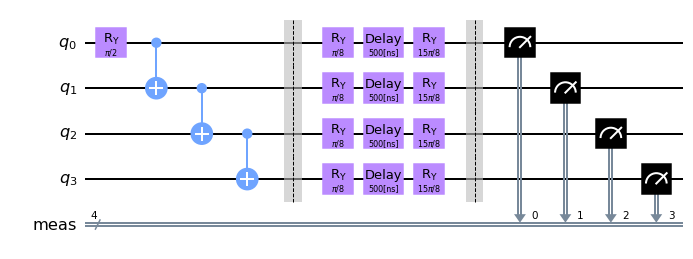

In [52]:
ckts_list[0].draw('mpl')

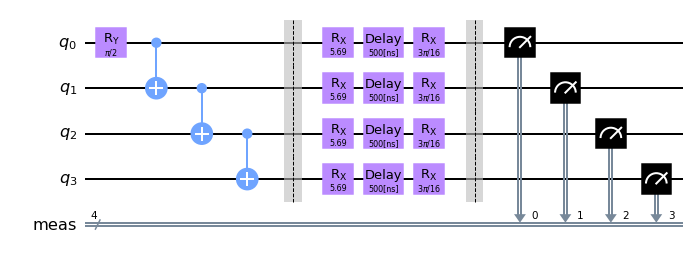

In [53]:
ckts_list[1].draw('mpl')

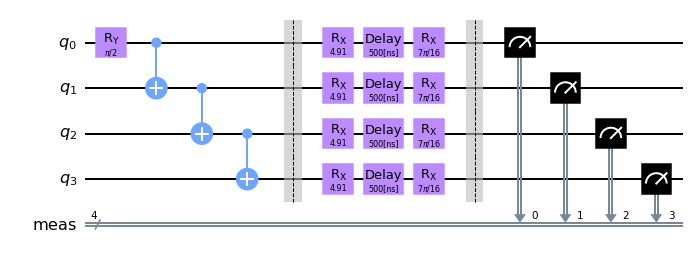

In [54]:
ckts_list[2].draw('mpl')

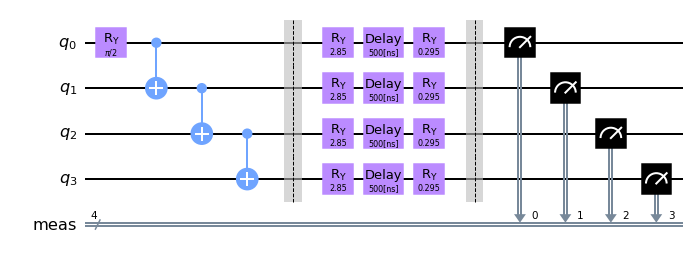

In [55]:
ckts_list[3].draw('mpl')

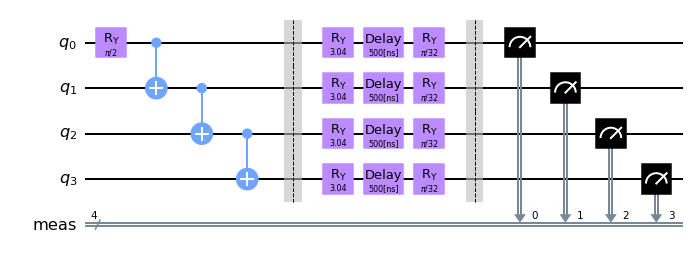

In [56]:
ckts_list[4].draw('mpl')

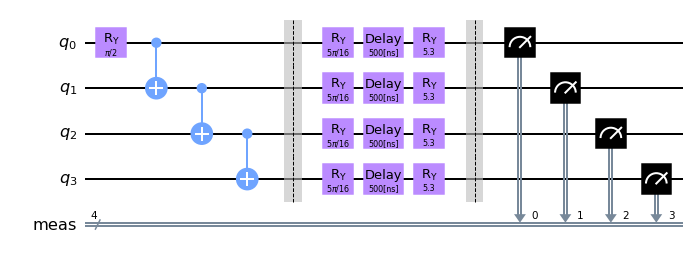

In [57]:
ckts_list[5].draw('mpl')

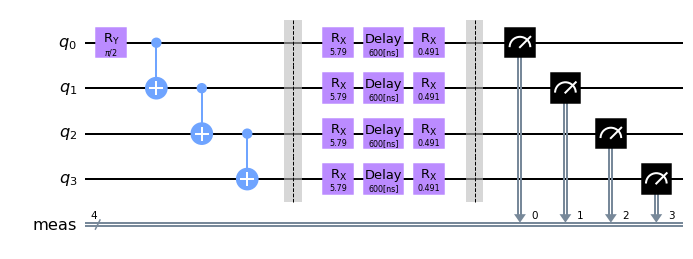

In [58]:
ckts_list[6].draw('mpl')

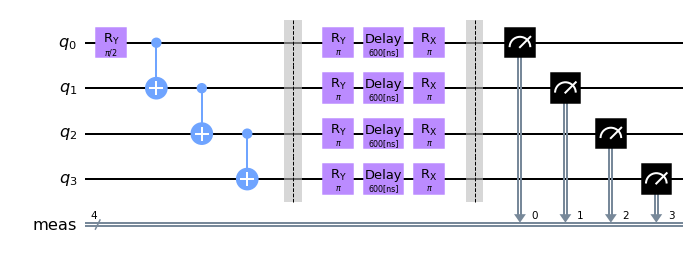

In [59]:
ckts_list[7].draw('mpl')

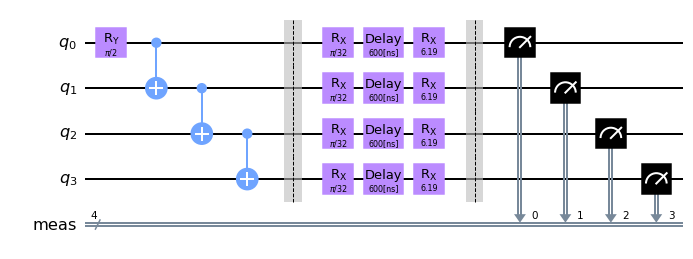

In [60]:
ckts_list[8].draw('mpl')

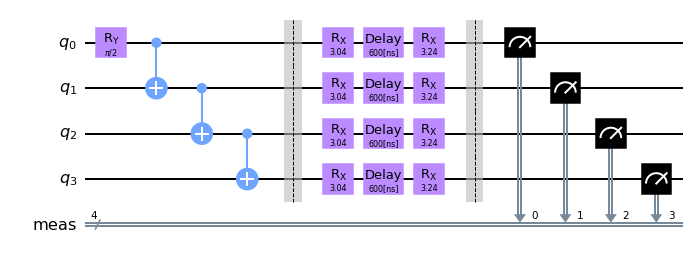

In [61]:
ckts_list[9].draw('mpl')

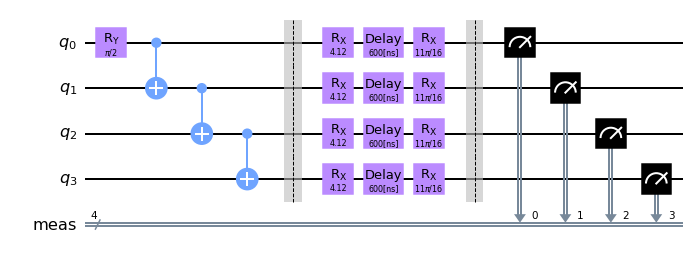

In [62]:
ckts_list[10].draw('mpl')

In [51]:
%qiskit_version_table